### Libraries

In [1]:
import numpy as np
import pandas as pd
import warnings

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [2]:
warnings.filterwarnings("ignore")

# 한글 처리
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

# 폰트 이름 얻어오기
font_name = fm.FontProperties(fname=font_path).get_name()

# 폰트 설정
plt.rcParams['font.family'] = font_name


### Load data

In [3]:
from dotenv import load_dotenv
import os 
load_dotenv()
df_train = pd.read_csv(os.getenv('TRAIN_DATA_PATH')).drop(columns=['ID'])
df_test = pd.read_csv(os.getenv('TEST_DATA_PATH')).drop(columns=['ID'])

df_train.head(8).to_csv('train_sample.csv', encoding = 'utf-8-sig', index = False)

# df_train = pd.read_csv('data/train.csv').drop(columns=['ID'])
# df_test = pd.read_csv('data/test.csv').drop(columns=['ID'])

In [4]:
# print(df_train.shape)
# df_train.head(2)

In [5]:
# print(df_test.shape)
# df_test.head(2)

### Preprocessing

#### 컬럼 제거

In [6]:
# 결측 비율 80% 이상 제거
missing_ratio = df_train.isnull().mean()
column_missing = missing_ratio[missing_ratio >= 0.8].index.tolist()

# nunique = 1 제거 
unique_counts = df_train.nunique()
column_nunique = unique_counts[unique_counts == 1].index.tolist()

# 컬럼 제거
dropped_columns = list(set(column_missing + column_nunique + ['배란 유도 유형']))

df_train = df_train.drop(columns=dropped_columns)
df_test = df_test.drop(columns=dropped_columns)

print("제거된 컬럼 개수:", len(dropped_columns))
print("제거된 컬럼:", dropped_columns)
print("df_train.shape:", df_train.shape)
print("df_test.shape:", df_test.shape)

제거된 컬럼 개수: 9
제거된 컬럼: ['불임 원인 - 여성 요인', '난자 채취 경과일', 'PGS 시술 여부', '임신 시도 또는 마지막 임신 경과 연수', 'PGD 시술 여부', '난자 해동 경과일', '착상 전 유전 검사 사용 여부', '배란 유도 유형', '배아 해동 경과일']
df_train.shape: (256351, 59)
df_test.shape: (90067, 58)


#### 29-38. astype(int)

In [7]:
# '횟수'를 포함하는 컬럼 찾기
count_columns = [col for col in df_train.columns if '횟수' in col]

def extract_number(value):
    if isinstance(value, str):
        return int(value[0])  # 맨 앞자리 숫자로 변환
    return value

for col in count_columns:
    df_train[col] = df_train[col].apply(extract_number).astype(int)
    df_test[col] = df_test[col].apply(extract_number).astype(int)
print("변환된 컬럼:", count_columns)

변환된 컬럼: ['총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수', '총 임신 횟수', 'IVF 임신 횟수', 'DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수', 'DI 출산 횟수']


#### 29,31,32. 총 시술 횟수 재정의

In [8]:
# 총 시술 횟수 재정의
def update_total_counts(df):
    df['총 시술 횟수'] = df['IVF 시술 횟수'] + df['DI 시술 횟수']
    df['총 임신 횟수'] = df['IVF 임신 횟수'] + df['DI 임신 횟수']
    df['총 출산 횟수'] = df['IVF 출산 횟수'] + df['DI 출산 횟수']
    return df

df_train = update_total_counts(df_train)
df_test = update_total_counts(df_test)

#### 2. 55-56. 나이

In [9]:
# # 중앙값으로 나이 변환
# def mapping_age(df, column, age):
#     df[column] = df[column].map(age)
#     return df

# # patient_age = {
# #     '만18-34세': 26,  
# #     '만35-37세': 36,  
# #     '만38-39세': 38.5,  
# #     '만40-42세': 41,  
# #     '만43-44세': 43.5,  
# #     '만45-50세': 47.5,  
# #     '알 수 없음': 999  # value_counts = 329 / 999 or 0 or np.nan or 중앙값으로 대체
# # }

# # egg_age = {
# #     '만20세 이하': 18,  
# #     '만21-25세': 23,  
# #     '만26-30세': 28,  
# #     '만31-35세': 33,  
# #     '알 수 없음': 999
# # }

# # sperm_age = {
# #     '만20세 이하': 18,  
# #     '만21-25세': 23,  
# #     '만26-30세': 28,  
# #     '만31-35세': 33,  
# #     '만36-40세': 38,  
# #     '만41-45세': 43,  
# #     '알 수 없음': 999
# # }


# patient_age = {
#     '만18-34세': 1,  
#     '만35-37세': 2,  
#     '만38-39세': 3,  
#     '만40-42세': 4,  
#     '만43-44세': 5,  
#     '만45-50세': 6,  
#     '알 수 없음': 999  # value_counts = 329 / 999 or 0 or np.nan or 중앙값으로 대체
# }

# egg_age = {
#     '만20세 이하': 1,  
#     '만21-25세': 2,  
#     '만26-30세': 3,  
#     '만31-35세': 4,  
#     '알 수 없음': 999
# }

# sperm_age = {
#     '만20세 이하': 1,  
#     '만21-25세': 2,  
#     '만26-30세': 3,  
#     '만31-35세': 4,  
#     '만36-40세': 5,  
#     '만41-45세': 6,  
#     '알 수 없음': 999
# }

# df_train = mapping_age(df_train, '시술 당시 나이', patient_age)
# df_test = mapping_age(df_test, '시술 당시 나이', patient_age)
# df_train = mapping_age(df_train, '난자 기증자 나이', egg_age)
# df_test = mapping_age(df_test, '난자 기증자 나이', egg_age)
# df_train = mapping_age(df_train, '정자 기증자 나이', sperm_age)
# df_test = mapping_age(df_test, '정자 기증자 나이', sperm_age)

#### 5. 특정 시술 유형 > One-hot encoding / 추가 시술 여부 컬럼 생성

In [10]:
# def add_trt(df):
#     types = ['IVF', 'ICSI', 'IUI', 'ICI', 'GIFT', 'FER', 'Generic DI', 'IVI', 'BLASTOCYST', 'AH', 'Unknown']
#     df['추가 시술 여부'] = df['특정 시술 유형'].apply(lambda x: 1 if sum(t in str(x) for t in types) >= 2 else 0)
    
#     return df

# df_train = add_trt(df_train)
# df_test = add_trt(df_test)

In [11]:
def ICSI_check(df):
    df['특정 시술 유형 - ICSI'] = np.where(df['시술 유형'] != 'IVF', -1,  # 시술 유형이 DI
                             np.where(df['특정 시술 유형'].str.contains('ICSI', na=False), 2, 1))

    df = df.drop(columns=['특정 시술 유형'])
    
    return df

df_train = ICSI_check(df_train)
df_test = ICSI_check(df_test)

#### 28. 배아 생성 주요 이유: 기증용, 난자 저장용, 배아 저장용, 연구용, 현재 시술용

In [12]:
def get_dummies(df):
#     df['배아 생성 주요 이유 - 현재 시술용'] = np.where(df['시술 유형'] != 'IVF', -1, 
#                              np.where(df['배아 생성 주요 이유'].str.contains('현재 시술용', na=False), 2, 1))
    
    df = df.drop(columns=['배아 생성 주요 이유'])
    
    return df

df_train = get_dummies(df_train)
df_test = get_dummies(df_test)

#### 남성/여성/부부 주/부 불임 원인 제거

In [13]:
# # 남성, 여성, 부부의 불임 원인 통합 (주, 부)
# def infertility_cause(df):
#     df['남성 불임 원인'] = ((df['남성 주 불임 원인'] == 1) | (df['남성 부 불임 원인'] == 1)).astype(int)
#     df['여성 불임 원인'] = ((df['여성 주 불임 원인'] == 1) | (df['여성 부 불임 원인'] == 1)).astype(int)
#     df['부부 불임 원인'] = ((df['부부 주 불임 원인'] == 1) | (df['부부 부 불임 원인'] == 1)).astype(int)
    
#     drop_cols = ['남성 주 불임 원인', '남성 부 불임 원인',
#                  '여성 주 불임 원인', '여성 부 불임 원인',
#                  '부부 주 불임 원인', '부부 부 불임 원인']
    
#     df = df.drop(columns=drop_cols, errors='ignore')

#     return df

# df_train = infertility_cause(df_train)
# df_test = infertility_cause(df_test)

In [14]:
# def drop_cols(df):
# #     cols = ['불임 원인 - 난관 질환', '불임 원인 - 남성 요인', 
# #             '불임 원인 - 배란 장애', '불임 원인 - 자궁경부 문제',
# #             '불임 원인 - 자궁내막증', '불임 원인 - 정자 농도', 
# #             '불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성', 
# #             '불임 원인 - 정자 형태' ]
#     cols = ['불임 원인 - 자궁경부 문제', '불임 원인 - 정자 면역학적 요인']
    
#     df = df.drop(columns=cols, errors='ignore')

#     return df

# df_train = drop_cols(df_train)
# df_test = drop_cols(df_test)

In [15]:
def drop_cols(df):
    cols = ['남성 주 불임 원인', '남성 부 불임 원인', 
            '여성 주 불임 원인', '여성 부 불임 원인',
            '부부 주 불임 원인', '부부 부 불임 원인']
    
    df = df.drop(columns=cols, errors='ignore')

    return df

df_train = drop_cols(df_train)
df_test = drop_cols(df_test)

In [16]:
# 난자 혼합 경과일, 배아 이식 경과일 groupby median fillna
def fill_nan(df_train, df_test):
    value1 = 0
    value2 = df_train[df_train['시술 유형'] == 'IVF'].groupby(['신선 배아 사용 여부', '총 생성 배아 수'])['배아 이식 경과일'].median().fillna(5)

    for df in [df_train, df_test]:
        df.loc[df['시술 유형'] == 'IVF', '난자 혼합 경과일'] = df.loc[df['시술 유형'] == 'IVF', '난자 혼합 경과일'].fillna(value1)
        df.loc[df['시술 유형'] == 'IVF', '배아 이식 경과일'] = df[df['시술 유형'] == 'IVF'].apply(
            lambda row: value2.get((row['신선 배아 사용 여부'], row['총 생성 배아 수']), 5) 
            if pd.isna(row['배아 이식 경과일']) else row['배아 이식 경과일'], axis=1
        )

    return df_train, df_test

df_train, df_test = fill_nan(df_train, df_test)

### Feature engineering

In [17]:
def advanced_features(df):
    epsilon = 1e-5  # 분모 0 방지를 위한 작은 값

#  바이너리(Yes/No) 변수 조합: 
    # 배란 자극, 단일 배아 이식, 착상 전 유전 진단, 동결/신선/기증 배아 사용, 대리모 여부
    binary_cols = [
        '배란 자극 여부', '단일 배아 이식 여부', '착상 전 유전 진단 사용 여부',
        '동결 배아 사용 여부', '신선 배아 사용 여부', '기증 배아 사용 여부', '대리모 여부'
    ]
    # 이미 0/1로 변환되어 있다고 가정하고, 총 개수 합산
    df['바이너리_합'] = df[binary_cols].sum(axis=1)
    # 예시로 특정 두 변수 간 상호작용 (배란 자극과 단일 배아 이식)
    df['배란자극x단일이식'] = df['배란 자극 여부'] * df['단일 배아 이식 여부']
    
    # 6. 경과일 차이: 배아 이식 경과일과 난자 혼합 경과일의 차이
    df['경과일_차이'] = np.abs(df['배아 이식 경과일'] - df['난자 혼합 경과일'])
    

    #  불임 원인 관련 피처: 여러 불임 원인 컬럼을 합쳐서 총 원인 수 산출
    infertility_cols = [
        '불명확 불임 원인', '불임 원인 - 난관 질환', '불임 원인 - 남성 요인',
        '불임 원인 - 배란 장애', '불임 원인 - 자궁경부 문제', '불임 원인 - 자궁내막증',
        '불임 원인 - 정자 농도', '불임 원인 - 정자 면역학적 요인',
        '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태'
    ]
    # 만약 해당 컬럼들이 문자열(Y/N)이라면 0/1로 변환
    for col in infertility_cols:
        if df[col].dtype == 'object':
            df[col] = df[col].map({'Y': 1, 'N': 0})
    df['불임원인_수'] = df[infertility_cols].sum(axis=1)
    
    #  ICSI와 배란자극 여부 상호작용: ICSI 효과가 배란자극 여부와 어떻게 연관되는지
    df['ICSIx배란자극'] = df['특정 시술 유형 - ICSI'] * df['배란 자극 여부']
    
    #  배아 저장 비율: 생성된 배아 중 얼마나 많은 배아가 저장되었는지
    df['배아저장비율'] = df['저장된 배아 수'] / (df['총 생성 배아 수'] + epsilon)
    
    return df

# 학습/테스트 데이터에 적용
df_train = advanced_features(df_train)
df_test  = advanced_features(df_test)

In [18]:
def feature_engineering_ivf(df):
    # IVF에만 적용
#     df = df[df['시술 유형'] == 'IVF']
    
    # 임신 성공률
    df['IVF 임신 성공률'] = df['IVF 임신 횟수'] / df['IVF 시술 횟수']
    df['배아 이식 대비 임신 성공률'] = df['총 임신 횟수'] / df['이식된 배아 수']
    
    # 출산 성공률
    df['IVF 출산 성공률'] = df['IVF 출산 횟수'] / df['IVF 임신 횟수']
    df['배아 이식 대비 출산 성공률'] = df['총 출산 횟수'] / df['이식된 배아 수']
    
    # 배아 이식
    df["이식된 배아 대비 이식 기간"] = df["배아 이식 경과일"] / df["이식된 배아 수"]
#     df['이식된 배아 대비 이식 기간'].fillna(0, inplace=True)
    
    # 난자
    df['총 난자 수'] = df['수집된 신선 난자 수'] + df['해동 난자 수']
    df['난자 사용률'] = df['혼합된 난자 수'] / df['총 난자 수']
    df['미세주입 X 난자 수'] = df['혼합된 난자 수'] - df['미세주입된 난자 수']
    
    # 배아
    df['총 배아 수'] = df['총 생성 배아 수'] + df['해동된 배아 수']
    df['미세주입 X 배아 수'] = df['총 생성 배아 수'] - df['미세주입에서 생성된 배아 수']
    df['미세주입 배아 생성 확률'] = df['미세주입에서 생성된 배아 수'] / df['미세주입된 난자 수']
    df['미세주입 배아 이식 확률'] = df['미세주입 배아 이식 수'] / df['미세주입에서 생성된 배아 수']
    df['미세주입 X 배아 생성 확률'] = df['미세주입 X 배아 수'] / df['미세주입 X 난자 수']
    df['총 배아 생성 확률'] = df['총 배아 수'] / df['총 난자 수']
    df['배아 이식 확률'] = df['이식된 배아 수'] / df['총 배아 수']
    df['동결&IVF 배아 이식 확률'] = (df['이식된 배아 수'] - df['미세주입 배아 이식 수']) / (df['총 배아 수'] - df['미세주입에서 생성된 배아 수'])
    
    # 나이
    df.loc[df['시술 유형'] == 'IVF', '나이 그룹별 평균 생성 배아 수'] = df.groupby('시술 당시 나이')['총 배아 수'].transform('mean')
    df.loc[df['시술 유형'] == 'IVF', '나이 그룹별 평균 이식 배아 수'] = df.groupby('시술 당시 나이')['이식된 배아 수'].transform('mean')
    # df.loc[df['시술 유형'] == 'IVF', '나이 그룹별 평균 배아 이식 확률'] = df.groupby('시술 당시 나이')['배아 이식 확률'].transform('mean')
    # df.loc[df['시술 유형'] == 'IVF', '나이 그룹별 평균 배아 생성 확률'] = df.groupby('시술 당시 나이')['총 배아 생성 확률'].transform('mean')
    df.loc[df['시술 유형'] == 'IVF', '나이 그룹별 평균 배아 이식 경과일'] = df.groupby('시술 당시 나이')['배아 이식 경과일'].transform('mean')

    # new
    df['신선 + 기증 + 동결'] = df[['신선 배아 사용 여부', '기증 배아 사용 여부', '동결 배아 사용 여부']].sum(axis=1)
    
    cols = ['총 난자 수','미세주입 X 난자 수','미세주입 X 배아 수','미세주입 X 배아 생성 확률','동결&IVF 배아 이식 확률']
    df = df.drop(columns=cols, errors='ignore')
    
    return df

df_train = feature_engineering_ivf(df_train)
df_test = feature_engineering_ivf(df_test)

In [19]:
def di_null(df):
    df.loc[df['시술 유형'] == 'DI'] = df.loc[df['시술 유형'] == 'DI'].fillna(-1)
    return df

df_train = di_null(df_train)
df_test = di_null(df_test)

In [20]:
# 결측 비율
missing_ratio = df_train.isnull().mean() * 100
print(missing_ratio)

시술 시기 코드               0.000000
시술 당시 나이               0.000000
시술 유형                  0.000000
배란 자극 여부               0.000000
단일 배아 이식 여부            0.000000
                         ...   
배아 이식 확률               5.245542
나이 그룹별 평균 생성 배아 수      0.000000
나이 그룹별 평균 이식 배아 수      0.000000
나이 그룹별 평균 배아 이식 경과일    0.000000
신선 + 기증 + 동결           0.000000
Length: 73, dtype: float64


In [21]:
# 결측값 대체
def replace_inf_and_nan(df, value_inf, value_na):
    df.replace([np.inf, -np.inf], value_inf, inplace=True)  # inf, -inf 변환
    df.fillna(value_na, inplace=True)  # NaN 변환
    return df

# 변환 적용
value_inf = 999 # 3 / 0
value_na = 999 # 0 / 0
df_train = replace_inf_and_nan(df_train, value_inf, value_na)
df_test = replace_inf_and_nan(df_test, value_inf, value_na)

In [22]:
def eiden_feature_engineering(df):
    # [Feature] 임신 대비 출산 성공률
    df['임신 대비 출산 성공률'] = df['총 출산 횟수'] / df['총 임신 횟수']
    df['임신 대비 출산 실패율'] = 1 - df['임신 대비 출산 성공률']
    
    #[Feature] 혼합된 난자 수 대비 이식된 배아 수
    df['혼합된 난자 수 대비 이식된 배아 수'] =  df['이식된 배아 수'] / df['혼합된 난자 수'] # 20250219_144117_0.73982_eiden
    # 만약 이식된 배아 수가 0이면 0으로 대체
    df.loc[df['이식된 배아 수'] == 0, '혼합된 난자 수 대비 이식된 배아 수'] = 0
    df.loc[df['혼합된 난자 수'] == 0, '혼합된 난자 수 대비 이식된 배아 수'] = 0

    return df

df_train = eiden_feature_engineering(df_train)
df_test = eiden_feature_engineering(df_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256351 entries, 0 to 256350
Data columns (total 2 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   혼합된 난자 수 대비 이식된 배아 수  256351 non-null  float64
 1   임신 성공 여부              256351 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 3.9 MB
None
       혼합된 난자 수 대비 이식된 배아 수       임신 성공 여부
count         256351.000000  256351.000000
mean               0.202340       0.258349
std                0.248809       0.437728
min                0.000000       0.000000
25%                0.000000       0.000000
50%                0.125000       0.000000
75%                0.250000       1.000000
max                3.000000       1.000000


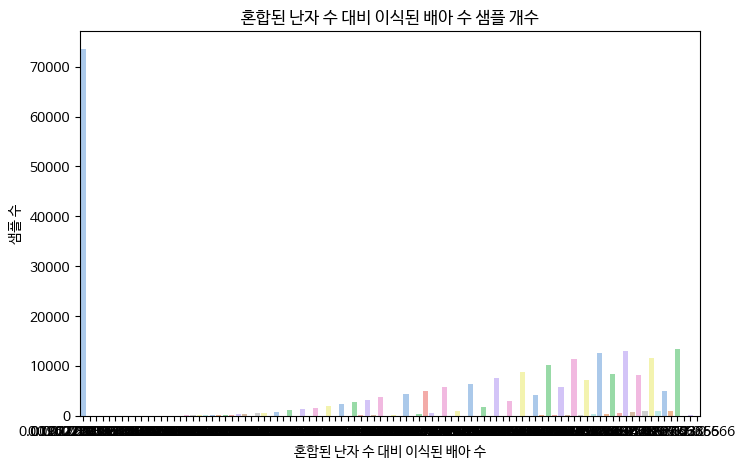

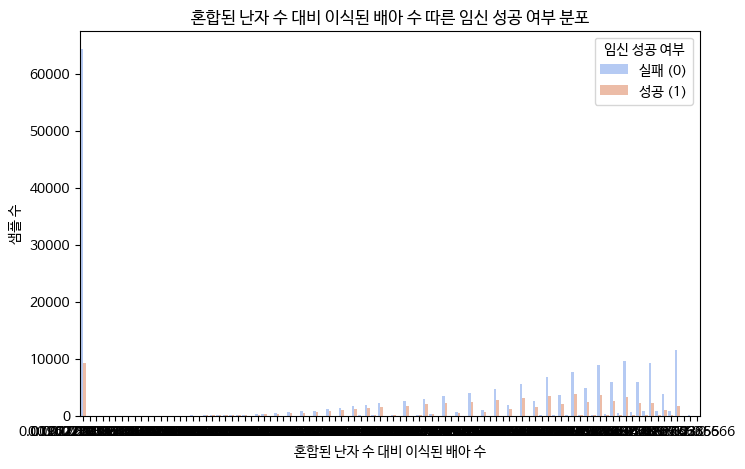

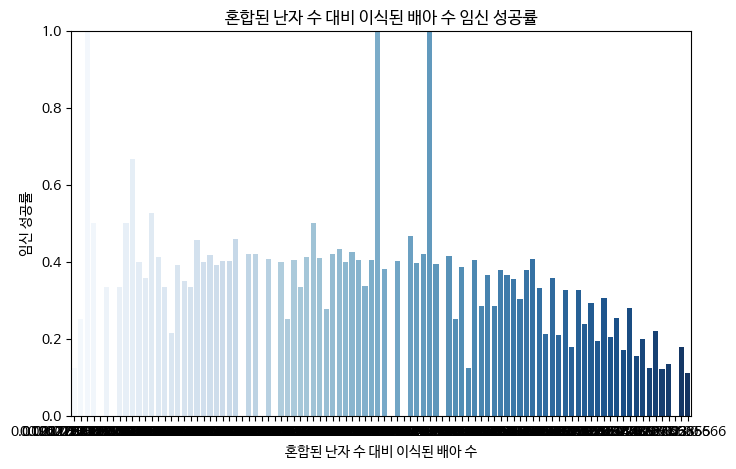

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analysis_임신성공여부(df, column_name):
    # 데이터 기본 정보 확인
    df = df[[column_name, '임신 성공 여부']]
    print(df.info())
    print(df.describe())

    # 1. 총 생성 배아 수별 데이터 개수 확인
    plt.figure(figsize=(8, 5))
    sns.countplot(x=column_name, data=df, palette='pastel')
    plt.title(f'{column_name} 샘플 개수')
    plt.xlabel(column_name)
    plt.ylabel('샘플 수')
    plt.show()

    # 2. 총 생성 배아 수별 임신 성공 여부 카운트
    plt.figure(figsize=(8, 5))
    sns.countplot(x=column_name, hue='임신 성공 여부', data=df, palette='coolwarm')
    plt.title(f'{column_name} 따른 임신 성공 여부 분포')
    plt.xlabel(column_name)
    plt.ylabel('샘플 수')
    plt.legend(title='임신 성공 여부', labels=['실패 (0)', '성공 (1)'])
    plt.show()

    # 3. 총 생성 배아 수별 성공률 계산
    success_rates = df.groupby(column_name)['임신 성공 여부'].mean()

    # 4. 총 생성 배아 수 대비 임신 성공률 시각화
    plt.figure(figsize=(8, 5))
    sns.barplot(x=success_rates.index, y=success_rates.values, palette='Blues')
    plt.title(f'{column_name} 임신 성공률')
    plt.xlabel(column_name)
    plt.ylabel('임신 성공률')
    plt.ylim(0, 1)  # 확률 범위 0~1 설정
    plt.show()

analysis_임신성공여부(df_train, column_name = '혼합된 난자 수 대비 이식된 배아 수')


### Feature selection

In [24]:
# object 타입 컬럼 확인
cat_features = list(df_train.select_dtypes(include=['object']).columns)
# cat_features

In [25]:
# LabelEncoder 적용
for col in cat_features:
    le = LabelEncoder() 
    df_train[col] = le.fit_transform(df_train[col])  
    df_test[col] = le.transform(df_test[col]) 

In [26]:
# # Scaling
# scaling_cols = [
#     '총 생성 배아 수', '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수', 
#     '미세주입 배아 이식 수', '저장된 배아 수', '미세주입 후 저장된 배아 수', '해동된 배아 수',
#     '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수', '혼합된 난자 수',
#     '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 혼합 경과일',
#     '배아 이식 경과일', '경과일_차이', '불임원인_수', '배아저장비율', '이식된 배아 대비 이식 기간',
#     '총 배아 수', '나이 그룹별 평균 생성 배아 수', '나이 그룹별 평균 이식 배아 수', '나이 그룹별 평균 배아 이식 경과일'
# ]

# scaler = MinMaxScaler()
# df_train[scaling_cols] = scaler.fit_transform(df_train[scaling_cols])
# df_test[scaling_cols] = scaler.transform(df_test[scaling_cols])

### Modeling

In [27]:
X = df_train.drop('임신 성공 여부', axis=1)
y = df_train['임신 성공 여부']
X_test = df_test

#### Stratified K-Fold 

In [28]:
# Stratified K-Fold 설정
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)

metrics = {model: [] for model in ['CatBoost']} # Ensemble
feature_importances = {model: [] for model in ['CatBoost']}
test_proba = {model: [] for model in ['CatBoost']} # Ensemble

# metrics = {model: [] for model in ['CatBoost', 'XGBoost', 'LightGBM', 'AdaBoost']} # Ensemble
# feature_importances = {model: [] for model in ['CatBoost', 'XGBoost', 'LightGBM', 'AdaBoost']}
# test_proba = {model: [] for model in ['CatBoost', 'XGBoost', 'LightGBM', 'AdaBoost']} # Ensemble

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"===== Fold {fold} =====")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # 모델 정의
    cat_model = CatBoostClassifier(
        iterations=700, learning_rate=0.03, depth=8, l2_leaf_reg=10,
        subsample=0.8, colsample_bylevel=0.8, random_strength=10, 
#         cat_features=cat_features, # 속도 너무 느려
        loss_function='Logloss', eval_metric='AUC', verbose=100, random_seed=123
    )

    # xgb_model = XGBClassifier(
    #     n_estimators=700, learning_rate=0.03, max_depth=7, min_child_weight=3,
    #     gamma=0.1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1,
    #     reg_lambda=1.0, verbosity=1, random_state=123
    # )

    # lgbm_model = LGBMClassifier(
    #     n_estimators=700, learning_rate=0.03, max_depth=-1, num_leaves=64,
    #     min_child_samples=20, subsample=0.8, colsample_bytree=0.8,
    #     reg_alpha=0.1, reg_lambda=1.0, verbosity=1, random_state=123
    # )
    
    # adaboost_model = AdaBoostClassifier(
    #     estimator=DecisionTreeClassifier(max_depth=2, min_samples_split=10, min_samples_leaf=5, random_state=123),
    #     n_estimators=500, learning_rate=0.05,
    #     algorithm="SAMME", random_state=123
    # )
    
#     ensemble_model = VotingClassifier(
#         estimators=[('catboost', cat_model), ('xgboost', xgb_model), ('lightgbm', lgbm_model), ('adaboost', adaboost_model)],
#         voting='soft', weights=[1, 1, 1, 0.8]
#     )


    # 모델 학습
    for model in [cat_model]: # ensemble_model
#     for model in [cat_model, xgb_model, lgbm_model, adaboost_model]: # ensemble_model
        model.fit(X_train, y_train)

    # 평가 함수
    def evaluate_model(model, X_val, y_true):
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]

        return {
            'Accuracy': accuracy_score(y_true, y_pred),
            'Precision': precision_score(y_true, y_pred),
            'Recall': recall_score(y_true, y_pred),
            'F1 Score': f1_score(y_true, y_pred),
            'ROC AUC Score': roc_auc_score(y_true, y_pred_proba)
        }

    # 평가 및 변수 중요도 저장
    for model_name, model in zip(metrics.keys(), [cat_model]): # ensemble_model
        metrics[model_name].append(evaluate_model(model, X_val, y_val))

    for model_name, model in zip(['CatBoost'], [cat_model]):
        feature_importances[model_name].append(model.feature_importances_)
        
    # 테스트 데이터 예측 확률 저장
    test_proba['CatBoost'].append(cat_model.predict_proba(X_test)[:, 1])
#     test_proba['XGBoost'].append(xgb_model.predict_proba(X_test)[:, 1])
#     test_proba['LightGBM'].append(lgbm_model.predict_proba(X_test)[:, 1])
#     test_proba['AdaBoost'].append(adaboost_model.predict_proba(X_test)[:, 1])
#     test_proba['Ensemble'].append(ensemble_model.predict_proba(X_test)[:, 1])

===== Fold 1 =====
0:	total: 58.5ms	remaining: 40.9s


100:	total: 1.29s	remaining: 7.65s
200:	total: 2.51s	remaining: 6.24s
300:	total: 3.72s	remaining: 4.93s
400:	total: 4.93s	remaining: 3.68s
500:	total: 6.22s	remaining: 2.47s
600:	total: 7.57s	remaining: 1.25s
699:	total: 8.85s	remaining: 0us
===== Fold 2 =====
0:	total: 11.5ms	remaining: 8.05s
100:	total: 1.26s	remaining: 7.47s
200:	total: 2.48s	remaining: 6.17s
300:	total: 3.72s	remaining: 4.93s
400:	total: 4.96s	remaining: 3.7s
500:	total: 6.25s	remaining: 2.48s
600:	total: 7.59s	remaining: 1.25s
699:	total: 8.87s	remaining: 0us
===== Fold 3 =====
0:	total: 12.3ms	remaining: 8.61s
100:	total: 1.25s	remaining: 7.4s
200:	total: 2.46s	remaining: 6.11s
300:	total: 3.68s	remaining: 4.88s
400:	total: 4.91s	remaining: 3.66s
500:	total: 6.19s	remaining: 2.46s
600:	total: 7.57s	remaining: 1.25s
699:	total: 8.84s	remaining: 0us
===== Fold 4 =====
0:	total: 13.3ms	remaining: 9.28s
100:	total: 1.24s	remaining: 7.34s
200:	total: 2.47s	remaining: 6.13s
300:	total: 3.66s	remaining: 4.85s
400:	tota

In [29]:
# 최종 변수 중요도 평균 계산
df_fi_list = []
for model_name, fi_list in feature_importances.items():
    avg_importance = np.mean(fi_list, axis=0)
    df_fi = pd.DataFrame({
        'Feature': X_train.columns,
        model_name: avg_importance 
    })
    df_fi = df_fi.sort_values(by=model_name, ascending=False).reset_index(drop=True)
    df_fi_list.append(df_fi)
    
df_fi_final = pd.concat(df_fi_list, axis=1)
# 모든 데이터프레임이 다 보이게 print
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_fi_final

,Feature,CatBoost
0,배아 이식 대비 임신 성공률,20.487699
1,배아 이식 대비 출산 성공률,19.307655
2,이식된 배아 대비 이식 기간,10.797384
3,이식된 배아 수,10.099873
4,배아 이식 확률,7.093595
5,혼합된 난자 수 대비 이식된 배아 수,3.400738
6,배아 이식 경과일,2.190643
7,시술 당시 나이,1.805168
8,총 배아 생성 확률,1.781551
9,배아저장비율,1.685527


In [30]:
# catboost 기준 변수 중요도 0.05 미만 변수 제거
df_cat = df_fi_final.iloc[:, :2]
df_selected = df_cat[df_cat['CatBoost'] > 0.05]
selected_features = df_selected['Feature'].tolist()

# 중요도가 높은 피처만 선택하여 새로운 데이터 생성
X = X[selected_features]
X_test = X_test[selected_features]

### Re-modeling

In [31]:
# Stratified K-Fold 설정
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)

metrics = {model: [] for model in ['CatBoost']} # Ensemble
feature_importances = {model: [] for model in ['CatBoost']}
test_proba = {model: [] for model in ['CatBoost']} # Ensemble

# metrics = {model: [] for model in ['CatBoost', 'XGBoost', 'LightGBM', 'AdaBoost']} # Ensemble
# feature_importances = {model: [] for model in ['CatBoost', 'XGBoost', 'LightGBM', 'AdaBoost']}
# test_proba = {model: [] for model in ['CatBoost', 'XGBoost', 'LightGBM', 'AdaBoost']} # Ensemble

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"===== Fold {fold} =====")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # 모델 정의
    cat_model = CatBoostClassifier(
        iterations=700, learning_rate=0.03, depth=8, l2_leaf_reg=10,
        subsample=0.8, colsample_bylevel=0.8, random_strength=10,
        loss_function='Logloss', eval_metric='AUC', verbose=100, random_seed=123
    )

    # xgb_model = XGBClassifier(
    #     n_estimators=700, learning_rate=0.03, max_depth=7, min_child_weight=3,
    #     gamma=0.1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1,
    #     reg_lambda=1.0, verbosity=1, random_state=123
    # )

    # lgbm_model = LGBMClassifier(
    #     n_estimators=700, learning_rate=0.03, max_depth=-1, num_leaves=64,
    #     min_child_samples=20, subsample=0.8, colsample_bytree=0.8,
    #     reg_alpha=0.1, reg_lambda=1.0, verbosity=1, random_state=123
    # )
    
    # adaboost_model = AdaBoostClassifier(
    #     estimator=DecisionTreeClassifier(max_depth=2, min_samples_split=10, min_samples_leaf=5, random_state=123),
    #     n_estimators=500, learning_rate=0.05,
    #     algorithm="SAMME", random_state=123
    # )
    
#     ensemble_model = VotingClassifier(
#         estimators=[('catboost', cat_model), ('xgboost', xgb_model), ('lightgbm', lgbm_model), ('adaboost', adaboost_model)],
#         voting='soft', weights=[1, 1, 1, 0.8]
#     )


    # 모델 학습
    for model in [cat_model]: # ensemble_model
#     for model in [cat_model, xgb_model, lgbm_model, adaboost_model]: # ensemble_model
        model.fit(X_train, y_train)

    # 평가 함수
    def evaluate_model(model, X_val, y_true):
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        
        # X_val의 이식된 배아 수가 0이면 y_pred_proba가 0이 되게 함
        y_pred_proba = np.where(X_val['이식된 배아 수'] == 0, 0, y_pred_proba)

        return {
            'Accuracy': accuracy_score(y_true, y_pred),
            'Precision': precision_score(y_true, y_pred),
            'Recall': recall_score(y_true, y_pred),
            'F1 Score': f1_score(y_true, y_pred),
            'ROC AUC Score': roc_auc_score(y_true, y_pred_proba)
        }

    # 평가 및 변수 중요도 저장
    for model_name, model in zip(metrics.keys(), [cat_model]): # ensemble_model
        metrics[model_name].append(evaluate_model(model, X_val, y_val))

    for model_name, model in zip(['CatBoost'], [cat_model]):
        feature_importances[model_name].append(model.feature_importances_)
        
    # 테스트 데이터 예측 확률 저장
    # [ADD] 이식된 배아 수가 0이면 0으로 예측하도록 함.
    y_test_proba = cat_model.predict_proba(X_test)[:, 1]
    y_test_proba = np.where(X_test['이식된 배아 수'] == 0, 0, y_test_proba)
    
    test_proba['CatBoost'].append(y_test_proba)
#     test_proba['XGBoost'].append(xgb_model.predict_proba(X_test)[:, 1])
#     test_proba['LightGBM'].append(lgbm_model.predict_proba(X_test)[:, 1])
#     test_proba['AdaBoost'].append(adaboost_model.predict_proba(X_test)[:, 1])
#     test_proba['Ensemble'].append(ensemble_model.predict_proba(X_test)[:, 1])

===== Fold 1 =====
0:	total: 9.97ms	remaining: 6.97s
100:	total: 1.19s	remaining: 7.08s
200:	total: 2.36s	remaining: 5.86s
300:	total: 3.52s	remaining: 4.67s
400:	total: 4.67s	remaining: 3.48s
500:	total: 5.91s	remaining: 2.35s
600:	total: 7.19s	remaining: 1.18s
699:	total: 8.39s	remaining: 0us
===== Fold 2 =====
0:	total: 9.5ms	remaining: 6.64s
100:	total: 1.21s	remaining: 7.15s
200:	total: 2.37s	remaining: 5.88s
300:	total: 3.52s	remaining: 4.66s
400:	total: 4.68s	remaining: 3.49s
500:	total: 5.92s	remaining: 2.35s
600:	total: 7.2s	remaining: 1.19s
699:	total: 8.42s	remaining: 0us
===== Fold 3 =====
0:	total: 9.15ms	remaining: 6.39s
100:	total: 1.18s	remaining: 7.02s
200:	total: 2.37s	remaining: 5.88s
300:	total: 3.5s	remaining: 4.64s
400:	total: 4.66s	remaining: 3.48s
500:	total: 5.87s	remaining: 2.33s
600:	total: 7.13s	remaining: 1.17s
699:	total: 8.35s	remaining: 0us
===== Fold 4 =====
0:	total: 9.21ms	remaining: 6.44s
100:	total: 1.16s	remaining: 6.9s
200:	total: 2.34s	remaining:

In [32]:
# 평가 지표 평균 출력
print("===== Stratified K-Fold 평균 성능 =====")
for model_name, model_metrics in metrics.items():
    avg_metrics = {metric: np.mean([fold_metric[metric] for fold_metric in model_metrics]) for metric in model_metrics[0]}
    
    print(f"\n== {model_name} Model ==")
    for metric, value in avg_metrics.items():
        print(f"{metric}: {value:.6f}")
        
# 최종 변수 중요도 평균 계산
df_fi_list = []
for model_name, fi_list in feature_importances.items():
    avg_importance = np.mean(fi_list, axis=0)
    df_fi = pd.DataFrame({
        'Feature': X_train.columns,
        model_name: avg_importance 
    })
    
    df_fi = df_fi.sort_values(by=model_name, ascending=False).reset_index(drop=True)
    df_fi_list.append(df_fi)
    
df_fi_final = pd.concat(df_fi_list, axis=1)

===== Stratified K-Fold 평균 성능 =====

== CatBoost Model ==
Accuracy: 0.745981
Precision: 0.539614
Recall: 0.114196
F1 Score: 0.188493
ROC AUC Score: 0.739826


In [33]:
# 모든 데이터프레임이 다 보이게 print
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_fi_final

,Feature,CatBoost
0,배아 이식 대비 출산 성공률,21.193398
1,이식된 배아 수,16.510298
2,배아 이식 대비 임신 성공률,10.342556
3,이식된 배아 대비 이식 기간,9.633340
4,배아 이식 확률,6.572200
5,혼합된 난자 수 대비 이식된 배아 수,4.783517
6,배아 이식 경과일,2.189013
7,시술 당시 나이,1.938646
8,배아저장비율,1.704333
9,나이 그룹별 평균 생성 배아 수,1.670928


### Prediction

In [34]:
# Best AUC 기록한 모델의 pred_proba로 선택
pred_proba = np.mean(test_proba['CatBoost'], axis=0)


# pred_proba = np.mean(test_proba['XGBoost'], axis=0)
# pred_proba = np.mean(test_proba['LightGBM'], axis=0)
# pred_proba = np.mean(test_proba['AdaBoost'], axis=0)
# pred_proba = np.mean(test_proba['Ensemble'], axis=0)

### Submission

In [35]:
# sample_submission = pd.read_csv('data/sample_submission.csv')
# sample_submission.head()

sample_submission = pd.read_csv(os.getenv('SUBMISSION_DATA_PATH'))
sample_submission.head()

,ID,probability
0,TEST_00000,0.0
1,TEST_00001,0.0
2,TEST_00002,0.0
3,TEST_00003,0.0
4,TEST_00004,0.0


In [36]:
# sample_submission['probability'] = pred_proba
# # 저장
# sample_submission.to_csv('data/submission.csv', index=False)
# sample_submission.head()

sample_submission['probability'] = pred_proba
# 저장
import datetime 
now = datetime.datetime.now()
save_path = os.path.join(f'./log/submission/{now.strftime("%Y%m%d_%H%M%S")}_{avg_metrics["ROC AUC Score"]:.5f}_eiden.csv')
sample_submission.to_csv(save_path, index=False)
sample_submission.head()

,ID,probability
0,TEST_00000,0.000000
1,TEST_00001,0.000000
2,TEST_00002,0.148036
3,TEST_00003,0.118924
4,TEST_00004,0.497948


In [37]:
# 확인용
submission = pd.read_csv(save_path)
submission.head()

,ID,probability
0,TEST_00000,0.000000
1,TEST_00001,0.000000
2,TEST_00002,0.148036
3,TEST_00003,0.118924
4,TEST_00004,0.497948
